# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [59]:
#!python pong.py

Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [60]:
#!pip3 install matplotlib

<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [61]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [62]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [63]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [64]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0, 0, 0]
This is how many times state [9,9,1,1,9] has been explored so far:
[0, 0, 0]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [65]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [66]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 0
Next action: -1
Next action: -1
Next action: 1
Next action: -1


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [67]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 1
Next action: 0
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [68]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [69]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0.0, 0.0, 0.0]
Q[9,9,1,1,9] is now: [0.0, 0.0, 0.0]


There are actually many different Q-learning algorithms available, but when people refer to Q-learning with no modifier, they usually mean the time-difference (TD) algorithm.  For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  This is the algorithm you will implement for this MP.

In supervised machine learning, the learner tries to imitate a reference label.  In reinforcement learning, there is no reference label.  Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [70]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [71]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [72]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [73]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.3125, 0.0, 0.0]
Q[9,9,1,1,8] is now [0.0, 0.0, 0.17046875000000003]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [74]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [75]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [76]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: -1
N1[9,9,1,1,8] is now [1, 0, 0]
Q1[9,9,1,1,8] is now [0.3125, 0.0, 0.0]
N2[9,9,1,1,8] starts out as [0, 0, 0]
Q2[9,9,1,1,8] starts out as [0.0, 0.0, 0.0]
N2[9,9,1,1,8] is now [1, 0, 0]
Q2[9,9,1,1,8] is now [0.3125, 0.0, 0.0]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [77]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [78]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.3125, 0.0, 0.0]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [79]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    If any action has been taken less than nfirst times, then choose one of those
    actions, uniformly at random.
    Otherwise, with probability epsilon, choose an action uniformly at random.
    Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [80]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 0
An epsilon-first action: -1
An epsilon-first action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [81]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [82]:
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [83]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [84]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 209 frames, score 0, max score 0
Completed 1 games, 5 rewards, 1185 frames, score 3, max score 3
Completed 2 games, 6 rewards, 1439 frames, score 0, max score 3
Completed 3 games, 7 rewards, 1620 frames, score 0, max score 3
Completed 4 games, 8 rewards, 1874 frames, score 0, max score 3
Completed 5 games, 9 rewards, 2082 frames, score 0, max score 3
Completed 6 games, 10 rewards, 2263 frames, score 0, max score 3
Completed 7 games, 12 rewards, 2700 frames, score 1, max score 3
Completed 8 games, 13 rewards, 2881 frames, score 0, max score 3
Completed 9 games, 14 rewards, 3062 frames, score 0, max score 3
Completed 10 games, 15 rewards, 3270 frames, score 0, max score 3
Completed 11 games, 16 rewards, 3478 frames, score 0, max score 3
Completed 12 games, 17 rewards, 3732 frames, score 0, max score 3
Completed 13 games, 18 rewards, 3913 frames, score 0, max score 3
Completed 14 games, 19 rewards, 4167 frames, score 0, max score 3
Completed 15 games, 21 rewa

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [85]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  2.253817988607297


Text(0, 0.5, 'Reward number')

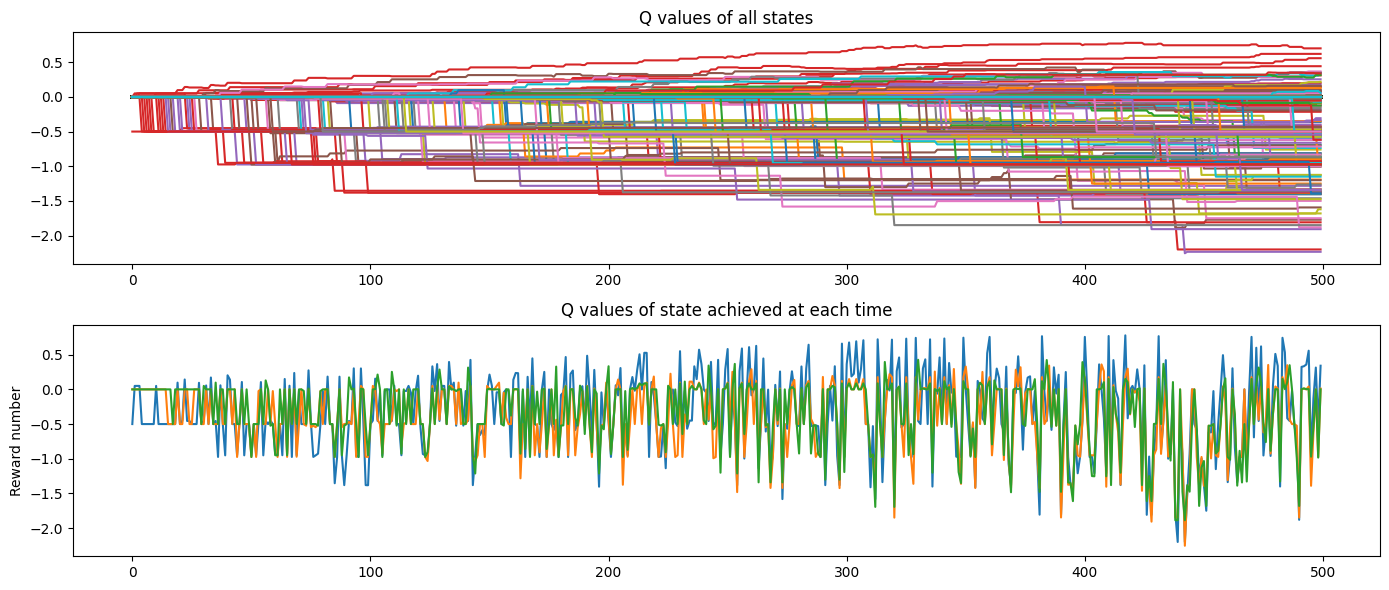

In [86]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6),layout='tight')
ax = [ fig.add_subplot(2,1,x) for x in range(1,3) ]
ax[0].plot(np.arange(0,len(q_states)),Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0,len(q_states)),q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [87]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 209 frames, score 1, max score 8
Completed 1 games, 4 rewards, 974 frames, score 2, max score 8
Completed 2 games, 5 rewards, 1182 frames, score 0, max score 8
Completed 3 games, 6 rewards, 1390 frames, score 0, max score 8
Completed 4 games, 12 rewards, 4743 frames, score 5, max score 8
Completed 5 games, 13 rewards, 4951 frames, score 0, max score 8
Completed 6 games, 14 rewards, 5132 frames, score 0, max score 8
Completed 7 games, 17 rewards, 6096 frames, score 2, max score 8
Completed 8 games, 18 rewards, 6350 frames, score 0, max score 8
Completed 9 games, 21 rewards, 7179 frames, score 2, max score 8
Completed 10 games, 24 rewards, 7745 frames, score 2, max score 8
Completed 11 games, 26 rewards, 8233 frames, score 1, max score 8
Completed 12 games, 27 rewards, 8441 frames, score 0, max score 8
Completed 13 games, 29 rewards, 8855 frames, score 1, max score 8
Completed 14 games, 30 rewards, 9036 frames, score 0, max score 8
Completed 15 games, 31 rew

KeyboardInterrupt: 

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,9),layout='tight')
ax = [ fig.add_subplot(3,1,x) for x in range(1,4) ]
ax[0].plot(np.arange(0,len(scores)),np.log10(1+np.array(scores)))
ax[0].plot([0,5000],np.log10([7,7]),'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991),np.log10(1+np.convolve(np.ones(10)/10,scores,mode='valid')))
ax[1].plot([0,4991],np.log10([7,7]),'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0,len(q_achieved)),q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [ ]:
q_learner.save('trained_model.npz')

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [ ]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

In [ ]:
help(submitted.deep_q.act)

In [ ]:
help(submitted.deep_q.learn)

In [ ]:
help(submitted.deep_q.save)

In [ ]:
help(submitted.deep_q.load)

<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [ ]:
!python grade.py

Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.